In [143]:
import mlxtend
import numpy as np
import pandas as pd
import re

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time
from functools import wraps

from scipy import stats

from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import k_means_

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn.decomposition import PCA

from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.metrics import silhouette_score

import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Resumo

O objetivo deste notbook é executar o trablho da disciplina de Data Mining I. O enunciado pedia que:

* Encontrássemos clusters de filmes semelhantes usando as notas dadas pelos usuários como features do modelo.
* Para lidar com o grande número de dimensões dos vetores de features, deveríamos usar uma transformada PCA para reduzir a dimensão do prodlema.
* Utilizar os algoritmos: KMeans e DBScan para gerar os clusters

A bases de 100k e 1M já haviam sido tratadas no trabalho anterior, por isso nenhum pré-processamento de limpeza dos dados foi feito. A ordem do Notebbok, seguiu o processo de experimentação realmente executado. Caso apenas as conclusões sejam de interesse, a sessão de conclusão resume o que foi encontrado.

# Importando o dataset

dataset depois do tratamento feito para a análise de Market Basket. 

In [114]:
ratingsDF_100k = pd.read_pickle("..\\ProcessedData\\df.pkl")
ratingsDF_1M = pd.read_pickle("..\\ProcessedData\\df_1M.pkl")

visualizando dataset 100k

In [115]:
ratingsDF_100k.head()

,uid,id,rating,timestamp,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,1997-12-04 15:55:49,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,1997-10-01 23:06:30,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,1998-01-04 04:37:51,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,154,242,3,1997-11-10 05:03:55,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,306,242,5,1997-10-10 17:16:33,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0


visualizando dataset 1M

In [116]:
ratingsDF_1M.head()

,uid,id,rating,timestamp,movie_title,Genres
0,1,1193,5,2000-12-31 22:12:40,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
1,2,1193,5,2000-12-31 21:33:33,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
2,12,1193,4,2000-12-30 23:49:39,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
3,15,1193,4,2000-12-30 18:01:19,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
4,17,1193,5,2000-12-30 06:41:11,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama


In [117]:
print("Número de usuários na base 100k %i" % ratingsDF_100k['uid'].nunique())
print("Número de usuários na base 1M %i" % ratingsDF_1M['uid'].nunique())

Número de usuários na base 100k 943
Número de usuários na base 1M 6040


In [118]:
print("Número de filmes na base 100k %i" % ratingsDF_100k['id'].nunique())
print("Número de filmes na base 1M %i" % ratingsDF_1M['id'].nunique())

Número de filmes na base 100k 1664
Número de filmes na base 1M 3706


## Criando os vetores de features dos filmes

Cada filme será representado pelas notas que cada um dos usuários da base deu para aquele filme. O que siginifica que **cada filme será representado por vetores esparsos de tamanho 943**.

Sabemos da exploração que não há duplicatas para a chave **uid, id**, então:

In [119]:
def visualize_ratings_sparsity(ratingsDF):
    ratings_id = ratingsDF.groupby(['id']).aggregate({'rating': len})
    
    print("Moda do número de usuários que viram o filme: %i" % ratings_id.rating.mode())
    print("Média do número de usuários que viram o filme: %i" % ratings_id.rating.mean())
    print("Número de filmes com apenas uma avaliação: %i" % (ratings_id.rating == 1).sum())
    
    plt.figure(),
    plt.subplot(1,2,1)
    ratings_id.rating.hist()
    plt.grid(True)
    plt.title("#usuários que viram o filme")
    plt.xlabel("uid")
    plt.ylabel("freq absoluta")

    plt.subplot(1,2,2)
    ratings_id.boxplot()
    plt.title("Boxplot que viram o filme")
    plt.rcParams['figure.figsize'] = (11,7)
    plt.show()
    
    return ratings_id

Esparsidade do vetor de features na base de 100k 

Moda do número de usuários que viram o filme: 1
Média do número de usuários que viram o filme: 59
Número de filmes com apenas uma avaliação: 135


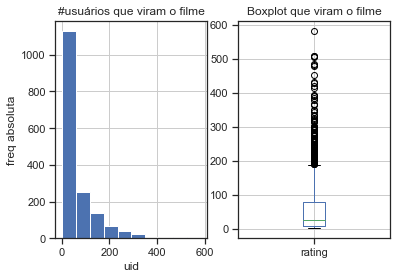

In [120]:
ratings_id_100k = visualize_ratings_sparsity(ratingsDF_100k)

Esparsidade do vetor de features na base de 1M 

Moda do número de usuários que viram o filme: 1
Média do número de usuários que viram o filme: 269
Número de filmes com apenas uma avaliação: 114


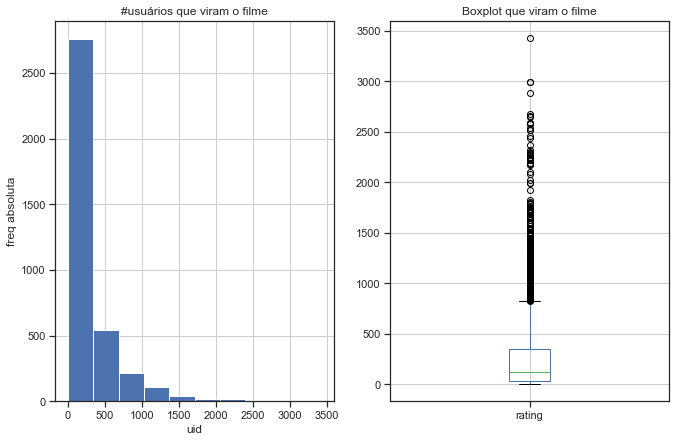

In [121]:
ratings_id_1M = visualize_ratings_sparsity(ratingsDF_1M)

## Filmes mais vistos

Para depois acharmos quais so clusters dos filmes mais populares vamos determinar quais sã eles primeiro. Após a observação dos box plot que mostram o quão esparsos são os vetores das bases, pode-se considerar que um filme popular na base de 100k tem pelo meos 150 visualizações e na base de 1M pelo menos 750

In [122]:
def determine_popular_filmss(ratings_id, threshold):
    popular_film = (ratings_id.rating > threshold)
    popular_ids = popular_film[popular_film]
    print("número de filmes populares %i" % popular_film.sum())
    return popular_ids

Para a base de 100k

In [123]:
popular_ids_100k = popular_ids_100k = determine_popular_filmss(ratings_id_100k, 150)

número de filmes populares 202


In [124]:
ratingsDF_100k[ratingsDF_100k['id'].isin(popular_ids_100k.index)].sample(10)

,uid,id,rating,timestamp,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
30272,72,69,4,1997-11-20 14:36:19,Forrest Gump (1994),1994-01-01,http://us.imdb.com/M/title-exact?Forrest%20Gum...,0,0,0,...,0,0,0,0,0,1,0,0,1,0
88111,72,124,4,1997-11-20 14:20:36,Lone Star (1996),1996-06-21,http://us.imdb.com/M/title-exact?Lone%20Star%2...,0,0,0,...,0,0,0,0,1,0,0,0,0,0
82759,710,340,4,1997-12-14 01:36:07,Boogie Nights (1997),1997-01-01,http://us.imdb.com/M/title-exact?Boogie+Nights...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63176,445,433,2,1998-03-27 08:33:37,Heathers (1989),1989-01-01,http://us.imdb.com/M/title-exact?Heathers%20(1...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83260,301,226,5,1997-12-14 05:27:02,Die Hard 2 (1990),1990-01-01,http://us.imdb.com/M/title-exact?Die%20Hard%20...,0,1,0,...,0,0,0,0,0,0,0,1,0,0
74548,158,435,5,1997-11-21 17:46:47,Butch Cassidy and the Sundance Kid (1969),1969-01-01,http://us.imdb.com/M/title-exact?Butch%20Cassi...,0,1,0,...,0,0,0,0,0,0,0,0,0,1
28649,213,235,1,1997-11-08 02:11:55,Mars Attacks! (1996),1996-12-13,http://us.imdb.com/M/title-exact?Mars%20Attack...,0,1,0,...,0,0,0,0,0,0,1,0,1,0
6566,541,304,4,1998-01-04 00:44:42,Fly Away Home (1996),1996-09-13,http://us.imdb.com/M/title-exact?Fly%20Away%20...,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3931,63,546,2,1997-10-01 23:16:29,Broken Arrow (1996),1996-02-09,http://us.imdb.com/M/title-exact?Broken%20Arro...,0,1,0,...,0,0,0,0,0,0,0,1,0,0
44882,488,186,4,1998-03-30 21:41:48,"Blues Brothers, The (1980)",1980-01-01,http://us.imdb.com/M/title-exact?Blues%20Broth...,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [125]:
popular_ids_1M = popular_ids_100k = determine_popular_filmss(ratings_id_1M, 750)

número de filmes populares 354


In [126]:
ratingsDF_1M[ratingsDF_1M['id'].isin(popular_ids_1M.index)].sample(10)

,uid,id,rating,timestamp,movie_title,Genres
528468,521,2012,3,2000-12-07 14:17:46,BACK TO THE FUTURE PART III (1990),Comedy|Sci-Fi|Western
258045,1693,1912,4,2000-11-20 08:39:25,OUT OF SIGHT (1998),Action|Crime|Romance
93570,1390,3255,3,2001-06-05 05:14:43,"LEAGUE OF THEIR OWN, A (1992)",Comedy|Drama
4508,1139,2355,4,2000-11-22 07:17:52,"BUG'S LIFE, A (1998)",Animation|Children's|Comedy
110165,5466,2858,4,2000-06-01 22:18:11,AMERICAN BEAUTY (1999),Comedy|Drama
357054,5140,1682,3,2000-07-29 12:55:39,"TRUMAN SHOW, THE (1998)",Drama
254728,2824,377,4,2000-10-27 04:43:07,SPEED (1994),Action|Romance|Thriller
423890,4354,2054,2,2000-08-02 05:02:51,"HONEY, I SHRUNK THE KIDS (1989)",Adventure|Children's|Comedy|Fantasy|Sci-Fi
396274,1142,3510,4,2000-11-22 07:22:48,FREQUENCY (2000),Drama|Thriller
251568,3967,50,3,2000-08-07 16:55:17,"USUAL SUSPECTS, THE (1995)",Crime|Thriller


# Criando vetores de features

Para fins desse trabalho, foi pedido para que usássemos as notas dadas pelos uuários como features. Outra informaçoes contidas na base poderiam ser usadas como: ano de lançamento e gênero.

In [66]:
def create_features(ratingsDF):
    df_pivoted = pd.pivot_table(ratingsDF, columns=['uid'], values=['rating'], index=['id'], aggfunc=np.max)
    df_pivoted.columns = df_pivoted.columns.get_level_values(1)
    return df_pivoted

In [68]:
%%time
df_features_100k = create_features(ratingsDF_100k)

Wall time: 1min 12s


In [62]:
df_features_100k.head(10)

uid,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
2,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.0,NaN,NaN,NaN,NaN,2.0,5.0,3.0,4.0,4.0,...,NaN,NaN,4.0,NaN,4.0,NaN,4.0,4.0,NaN,NaN
8,1.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
9,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,4.0,...,NaN,1.0,4.0,5.0,3.0,5.0,3.0,NaN,NaN,3.0


In [72]:
%%time
df_features_1M = create_features(ratingsDF_1M)

Wall time: 11min 51s


In [73]:
df_features_1M.head(10)

uid,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# para evitar o retreino das features que pode demorar um pouco especialmete para a base de 1M
df_features_100k.to_pickle('../ProcessedData/temp/df_features_100k.pkl')
df_features_1M.to_pickle('../ProcessedData/temp/df_features_1M.pkl')

In [3]:
# para evitar o retreino das features que pode demorar um pouco especialmete para a base de 1M
df_features_100k = pd.read_pickle('../ProcessedData/temp/df_features_100k.pkl')
df_features_1M = pd.read_pickle('../ProcessedData/temp/df_features_1M.pkl')

## Fill de valores nulos

Os algoritimos que vamos utilizar são sensíveis aos valores nulos. Para diminuir esse efeito, podemos substituir zeros pela média das notas dos filmes desconsiderando os valores 0 (que são NAN na verdade);

In [4]:
def fillNa_with_non_na_avg_rating_for_film(df_pivoted): 
    # Obs: a função *fillna* por linha não está implementada no Pandas, por isso as transposições
    filmMeanRating = df_pivoted.mean(axis=1)
    df_pivoted_ = df_pivoted.T.fillna(filmMeanRating).T
    return df_pivoted_

In [5]:
%%time
df_features_100k_ = fillNa_with_non_na_avg_rating_for_film(df_features_100k)

Wall time: 339 ms


In [6]:
df_features_100k_.T.describe()

id,1,2,3,4,5,6,7,8,9,10,...,1672,1673,1674,1675,1676,1677,1678,1679,1681,1682
count,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,...,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0
mean,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
std,0.642041,0.359043,0.372773,0.453487,0.284302,0.212022,0.632690,0.482161,0.586278,0.309907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
25%,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
50%,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
75%,4.000000,3.206107,3.033333,3.550239,3.302326,3.576923,4.000000,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0


In [7]:
%%time
df_features_1M_ = fillNa_with_non_na_avg_rating_for_film(df_features_1M)

Wall time: 805 ms


O data to enrich, será usado para mostrar os nomes e outras informações cadastrais dos filmes

## DataSet Cadastral

Pode-se recompor a base cadastral de filmes a partir das bases de ratings fazendo-se uma agregação. Isso evita que tenhamos que refazer reprocessametos já feitos na composição da base de ratings.

In [26]:
to_enrich_100k = ratingsDF_100k.groupby('id').agg(
    {'timestamp':'first',
     'id':'first',
     'movie_title':'first', 
     'release_date':'first',
     'unknown':'first', 
     'Action':'first', 
     'Adventure':'first', 
     'Animation':'first', 
     'Children\'s':'first',
       'Comedy':'first', 
     'Crime':'first', 
     'Documentary':'first', 
     'Drama':'first', 
     'Fantasy':'first', 
     'Film-Noir':'first',
       'Horror':'first', 
     'Musical':'first', 
     'Mystery':'first', 
     'Romance':'first', 
     'Sci-Fi':'first', 
     'Thriller':'first', 
     'War':'first',
    'Western':'first'
    })

In [27]:
to_enrich_100k.head(5)

,timestamp,id,movie_title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
id,,,,,,,,,,,,,,,,,,,,,
1,1998-02-17 17:28:52,1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1997-09-30 16:14:13,2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1997-11-08 04:30:41,3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1998-02-03 15:18:17,4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,1998-03-03 06:29:36,5,Copycat (1995),1995-01-01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [28]:
to_enrich_1M = ratingsDF_1M.groupby('id').agg(
    {'timestamp':'first', 
     'id':'first',
     'movie_title':'first', 
     'Genres':'first',
    })

In [29]:
to_enrich_1M.head(5)

,timestamp,id,movie_title,Genres
id,,,,
1,2001-01-06 23:37:48,1,TOY STORY (1995),Animation|Children's|Comedy
2,2001-01-10 23:11:07,2,JUMANJI (1995),Adventure|Children's|Fantasy
3,2000-12-30 01:33:42,3,GRUMPIER OLD MEN (1995),Comedy|Romance
4,2000-12-31 03:10:03,4,WAITING TO EXHALE (1995),Comedy|Drama
5,2000-12-30 02:54:41,5,FATHER OF THE BRIDE PART II (1995),Comedy


# Decomposição do vetor de features

In [34]:
def get_pca(df_flattern, pca_dim):
    
    pca = PCA(n_components=pca_dim).fit(df_flattern)
    df_pca = pd.DataFrame(pca.transform(df_flattern))
    
    return df_pca, pca

def visualize_pca(df_pca, pca):
    pca_dim = pca.n_components
    cumulativeVar = pd.Series(pca.explained_variance_ratio_.cumsum())
    
    plt.figure()
    cumulativeVar.plot()
    
    plt.grid(True)
    plt.title("soma cumulativa das variâncias")
    plt.xlabel("#PCA components")
    plt.ylabel("variância")
    plt.show()
    
    # plt.figure().gca(projection='3d')
    plt.figure()
    plt.scatter(df_pca[0], df_pca[1])
    plt.grid(True)
    plt.title("filmes")
    plt.xlabel("pca_0")
    plt.ylabel("pca_1")
    plt.show()

## PCA para a base de 100K

In [35]:
df_pca_100k, pca_full_100k = get_pca(df_features_100k_, None)

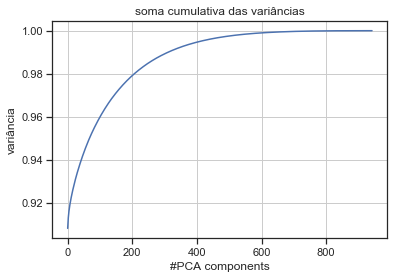

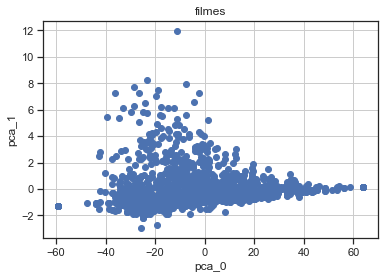

In [37]:
visualize_pca(df_pca_100k, pca_full_100k)

Observando o gráfico, percbe-se a concentração de enrgia nas primeiras componentes com apenas 3 temos que:

In [38]:
# limpando a memória
pca_full_100k = None

In [39]:
df_pca_100k, pca_3_100k = get_pca(df_features_100k_, 3)

In [40]:
print("energia conservada pelas %i primeiras componentes do PCA %f" % (pca_3_100k.n_components, pca_3_100k.explained_variance_ratio_.sum())) 

energia conservada pelas 3 primeiras componentes do PCA 0.912999


Trabalhar com um número maior de componentes dificultaria a visualização e a ordem de grandeza das variâncias cai muito ao longo dos eixos

## PCA para a base de 1M

In [41]:
df_pca_1M, pca_full_1M = get_pca(df_features_1M_, None)

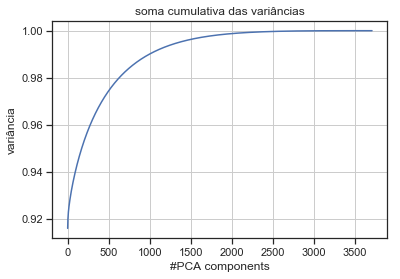

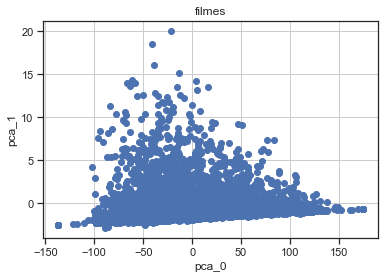

In [42]:
visualize_pca(df_pca_1M, pca_full_1M)

In [43]:
# limpando a memória
pca_full_1M = None

Observando o gráfico, percbe-se a concentração de enrgia nas primeiras componentes com apenas 3 temos que:

In [44]:
df_pca_1M, pca_3_1M = get_pca(df_features_1M_, 3)

In [45]:
print("energia conservada pelas %i primeiras componentes do PCA %f" % (pca_3_1M.n_components, pca_3_1M.explained_variance_ratio_.sum())) 

energia conservada pelas 3 primeiras componentes do PCA 0.919143


Novamente trabalhar com um número maior de componentes dificultaria a visualização e a ordem de grandeza das variâncias cai muito ao longo dos eixos

# Clusterização

Posdemos executar a clusterização no espaço não transformado pelo PCA enquanto isso não gerar problemas de desempenho. Pode-se usar o PCA para fazer a projeção para 2D e faciliar a visualização dos clustes

In [106]:
def list_n_films_from_clusters(df_full, n):
    num_clusters = df_full.cluster.nunique()
    for c in range(0, num_clusters):
        in_cluster = df_full[df_full.cluster == c]
        cluster_sz = len(in_cluster)
        if cluster_sz> 0:
            print_sz = (cluster_sz, n)[cluster_sz > n]
            print("Cluster %i" % c)
            print(in_cluster.sample(n=print_sz)['movie_title'])            

In [178]:
def calculate_silhouette_for_clusters(df_pca, labels, metric='euclidean'):
    silhouete = silhouette_samples(df_pca, labels, metric=metric)
    d = {'labels': labels, 'silhouete': silhouete}
    temp_df = pd.DataFrame(d)
    return temp_df.groupby(['labels']).mean()

In [102]:
def visualize_clusters(df):

    filmsInClusterCount = pd.Series(data=df.groupby(['cluster']).count()[0])
    plt.figure(),
    filmsInClusterCount.plot.bar(x='index', y='cluster', rot=0)
    plt.xlabel("cluster")
    plt.grid(True)
    plt.ylabel("freq. absoluta")
    plt.title('distribuição nos clusters')
    plt.show()
    
    plt.figure(),
    g = sns.pairplot( df, hue="cluster", x_vars=df.columns, y_vars=df.columns)
    plt.show()

In [89]:
def enrich_columns(df, to_enrich):
#     df_full = pd.concat([df, to_enrich], axis=0, join='inner')
    df_ = df.copy()
    df_['id'] = to_enrich['id']
    df_full = df_.join(to_enrich, how='left', rsuffix='r')    
    df_full.drop(columns=['idr'], inplace=True)
    df_full[df_full['cluster'] == 0].head(10)
    df_full = df_full.rename(mapper={0:'pca_0', 1:'pca_1', 2:'pca_2'}, axis='columns')
    return df_full

In [127]:
def where_popular(df_full, popular_ids):
    populares = df_full[df_full['id'].isin(popular_ids.index)]
    contagem = pd.Series(data=populares.groupby(['cluster']).count()['pca_0'])
    
    plt.figure()
    contagem.plot.bar()
    plt.xlabel("cluster")
    plt.grid(True)
    plt.ylabel("freq. absoluta")
    plt.title('distribuição dos filmes populares nos clusters')
    plt.show()
    
    return populares, contagem

## Kmeans usando a norma L2 como medida de dessimilaridade

Primeiro devemos determinar o número de clusters

In [46]:
def loss_vs_n_clusters(n_clusters_range, df_for_clustering):
    scores = []
    time_elapsed = []
    
    for n in n_clusters_range:
        start_time = time.time()
        kmeans = KMeans(n_clusters=int(n)).fit(df_for_clustering)
        elapsed_time = time.time() - start_time
        scores.append(kmeans.inertia_)
        time_elapsed.append(elapsed_time)
    
    plt.figure(),
    plt.subplot(2,1,1)
    plt.plot( n_clusters_range, scores)
    plt.grid(True)
    plt.title("score x #clusters")
    plt.ylabel("score")
    plt.subplot(2,1,2)
    plt.plot( n_clusters_range, time_elapsed)
    plt.grid(True)
    plt.xlabel("#clusters")
    plt.ylabel("time_elapsed")
    plt.show()
    
    return scores, time_elapsed

### Base de 100k

#### Treinamento

Para determinar o número de clusters, procuramos por um joelho na gráfico de loss (norma L@) vs número de clusters

In [49]:
th_min = 0
th_max = 2
n_clusters_range = np.rint(np.logspace(th_min,th_max,num=30))

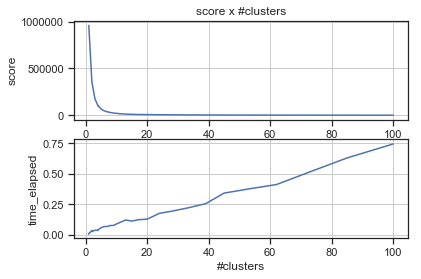

In [50]:
scores_100k, time_elapsed_100k = loss_vs_n_clusters(n_clusters_range, df_pca_100k)

Por inspeção, há um joelho entre 10 e 20, vou repetir a análise para aumentar o range de 10 a 20

In [51]:
n_clusters_range = np.linspace(5,20,num=10)

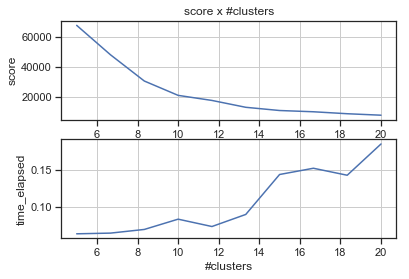

In [52]:
scores_100k, time_elapsed_100k = loss_vs_n_clusters(n_clusters_range, df_pca_100k)

Por inspeção n=10, parece uma boa definição para o joelho

In [53]:
n_100k = 10
kmeans_100k = KMeans(n_clusters=n_100k).fit(df_pca_100k)

# adding cluster column to dataset
cluster_labels_100k = kmeans_100k.labels_
df_100k = df_pca_100k.copy()
df_100k['cluster'] = cluster_labels_100k

#### Visualizando so resultados

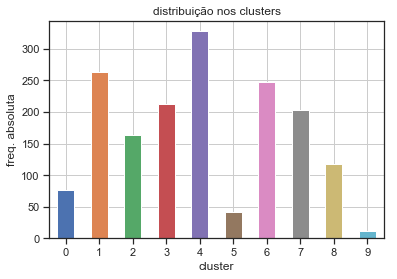

C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc

<Figure size 432x288 with 0 Axes>

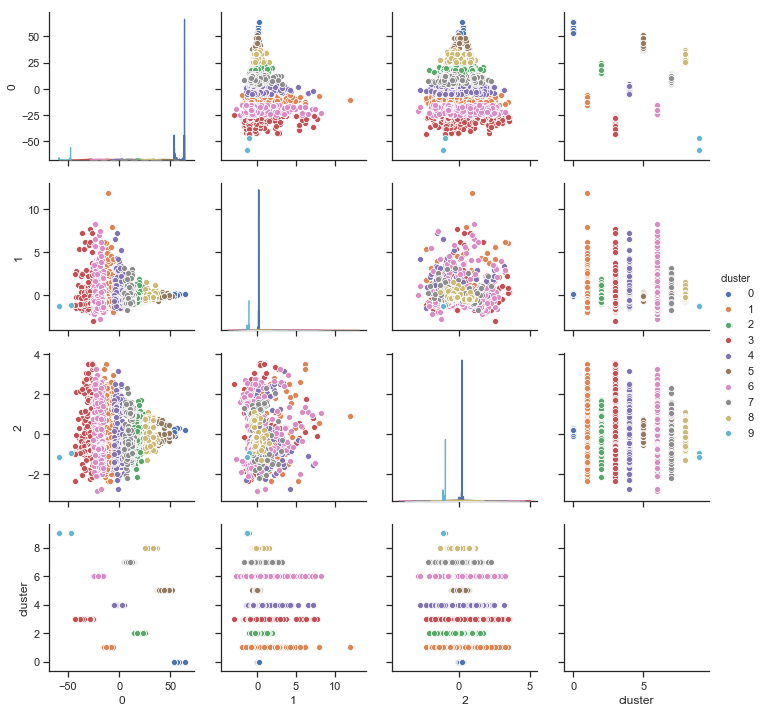

In [103]:
visualize_clusters(df_100k)

##### Observação
> Aparentemente, os clusters usados separaram os dados (para a maioria dos clusters), com planos ortogonais ao eixo 0 do PCA.

In [90]:
df_full_100k = enrich_columns(df_100k, to_enrich_100k)

In [92]:
df_full_100k.head(5)

,pca_0,pca_1,pca_2,cluster,id,timestamp,movie_title,release_date,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,-24.735530,5.805738,-0.350249,6,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-4.009658,2.882217,2.483557,4,1.0,1998-02-17 17:28:52,Toy Story (1995),1995-01-01,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.331258,1.437456,-0.431839,4,2.0,1997-09-30 16:14:13,GoldenEye (1995),1995-01-01,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-14.598549,1.232487,0.178331,1,3.0,1997-11-08 04:30:41,Four Rooms (1995),1995-01-01,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-6.915478,1.877837,-1.029404,1,4.0,1998-02-03 15:18:17,Get Shorty (1995),1995-01-01,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Intra cluster coesion

Coesão intra cluster usando Silhouette Coefficient:


>Compute the mean Silhouette Coefficient of all samples.
>
>The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for >each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and >the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 ><= n_labels <= n_samples - 1.


Idealmente esse coeficiente é 1 se a amostra pertece ao cluster

In [179]:
clusters_silh_100k = calculate_silhouette_for_clusters(df_pca_100k, df_full_100k['cluster'])

Os clusters em ordem de coesão

In [180]:
clusters_silh_100k .sort_values(['silhouete'], ascending=False)

,silhouete
labels,
9,0.900463
0,0.897088
8,0.551153
2,0.541262
5,0.538823
7,0.490762
4,0.457607
3,0.448583
1,0.421451


**Conclusão**
> Os clusters coesos são o 9 e o 0. Os demais tem filmes que estão "tão distantes do seus centroids quanto da amostra mais próxima do cluster mais próximo" (em uma interpretação informal do score shilhouete)

In [108]:
list_n_films_from_clusters(df_full_100k, 10)

Cluster 0
1352         Shadow of Angels (Schatten der Engel) (1976)
1483                     Man in the Iron Mask, The (1998)
1309                         Very Natural Thing, A (1974)
1554                                  Safe Passage (1994)
1570                               Quartier Mozart (1992)
1546                              Shadows (Cienie) (1988)
1475                            Bhaji on the Beach (1993)
1607                                                  NaN
1604                            He Walked by Night (1948)
1653    Entertaining Angels: The Dorothy Day Story (1996)
Name: movie_title, dtype: object
Cluster 1
1048              She's the One (1996)
740                   Jane Eyre (1996)
1055    Simple Twist of Fate, A (1994)
399       Three Musketeers, The (1993)
272           Good Will Hunting (1997)
1394         Swept from the Sea (1997)
350                      Fallen (1998)
653               Touch of Evil (1958)
732                        Dave (1993)
25              

#### Onde estão os filmes populares?

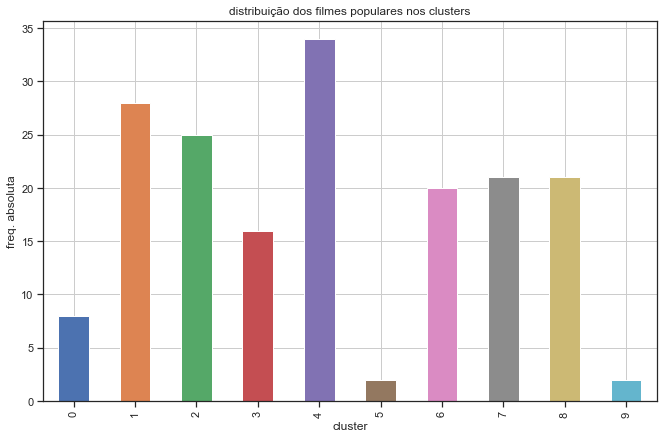

In [129]:
df_popular_100k, contagem_100k = where_popular(df_full_100k, popular_ids_100k)

**conclsão**
> Hà filmes populares em todos os clusters, mas são mais frequentes nos clusters 4 e 1

visualizando os filmes populares ao longo do clusters

In [130]:
list_n_films_from_clusters(df_popular_100k, 5)

Cluster 0
1641                                      Dadetown (1995)
1573    Spirits of the Dead (Tre passi nel delirio) (1...
594                                          Heavy (1995)
1552                                   Hunted, The (1995)
1307        Carmen Miranda: Bananas Is My Business (1994)
Name: movie_title, dtype: object
Cluster 1
293                 Donnie Brasco (1997)
50                      Star Wars (1977)
1101    Six Degrees of Separation (1993)
858         Amityville: Dollhouse (1996)
908                    Half Baked (1998)
Name: movie_title, dtype: object
Cluster 2
111             Truth About Cats & Dogs, The (1996)
1517                            Race the Sun (1996)
899                        Winter Guest, The (1997)
349                                Hard Rain (1998)
969     Winnie the Pooh and the Blustery Day (1968)
Name: movie_title, dtype: object
Cluster 3
47                     Ed Wood (1994)
1387                      Fall (1997)
21      Muppet Treasure Island

### Base de 1M

#### Treinamento

Para determinar o número de clusters, procuramos por um joelho na gráfico de loss (norma L@) vs número de clusters

In [132]:
th_min = 0
th_max = 2.5
n_clusters_range = np.rint(np.logspace(th_min,th_max,num=30))

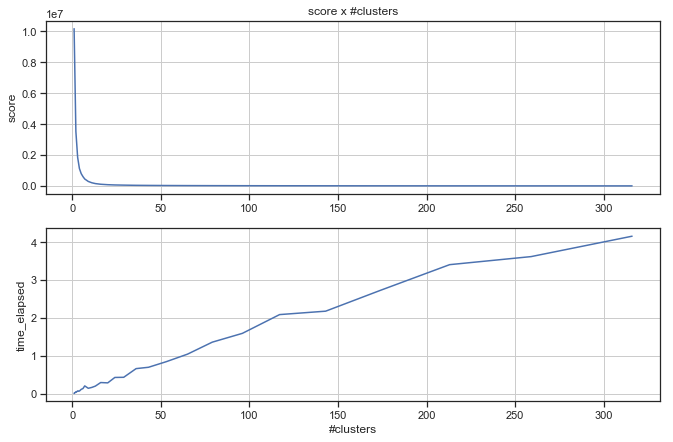

In [133]:
scores_1M, time_elapsed_1M = loss_vs_n_clusters(n_clusters_range, df_pca_1M)

Por inspeção, há um joelho entre 10 e 20, vou repetir a análise para aumentar o range de 10 a 20

In [137]:
n_clusters_range = np.linspace(10,50,num=40)

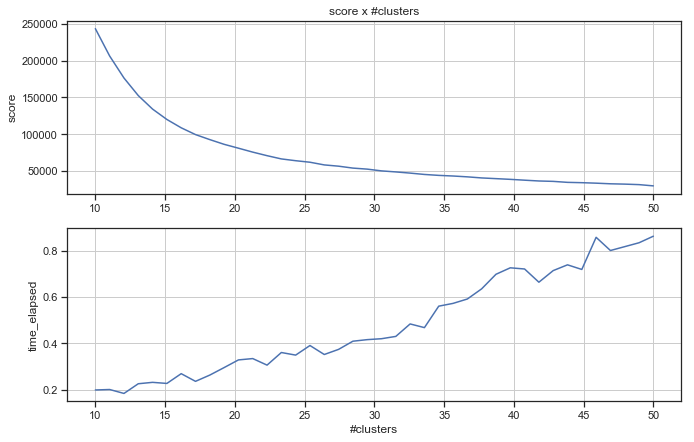

In [138]:
scores_1M, time_elapsed_1M = loss_vs_n_clusters(n_clusters_range, df_pca_1M)

Por inspeção n=20, parece uma boa definição para o joelho

In [139]:
n_1M = 20
kmeans_1M = KMeans(n_clusters=n_1M).fit(df_pca_1M)

# adding cluster column to dataset
cluster_labels_1M = kmeans_1M.labels_
df_1M = df_pca_1M.copy()
df_1M['cluster'] = cluster_labels_1M

#### Visualizando so resultados

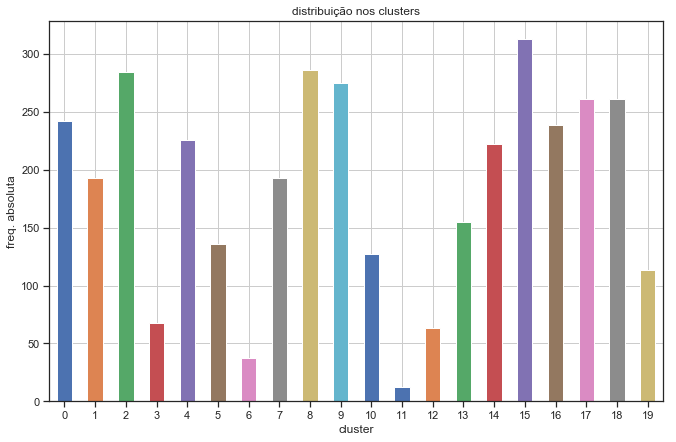

C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc

<Figure size 792x504 with 0 Axes>

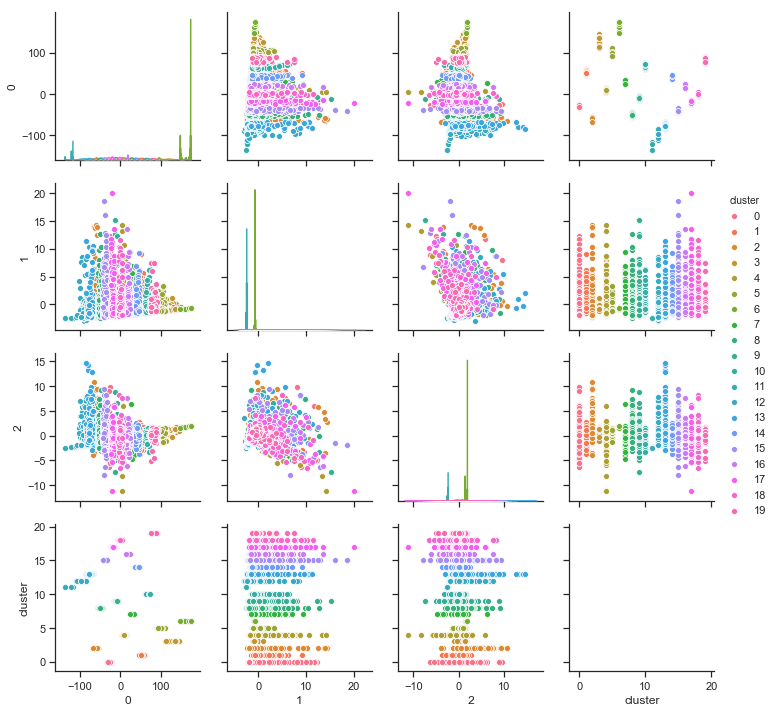

In [140]:
visualize_clusters(df_1M)

##### Observação
> Novamente, os clusters usados separaram os dados (para a maioria dos clusters), com planos ortogonais ao eixo 0 do PCA.

In [141]:
df_full_1M = enrich_columns(df_1M, to_enrich_1M)

In [142]:
df_full_1M.head(5)

,pca_0,pca_1,pca_2,cluster,id,timestamp,movie_title,Genres
0,-70.706506,7.520658,3.235887,13,NaN,NaT,NaN,NaN
1,2.944293,5.531351,-1.904017,18,1.0,2001-01-06 23:37:48,TOY STORY (1995),Animation|Children's|Comedy
2,17.291953,2.307956,-1.671769,16,2.0,2001-01-10 23:11:07,JUMANJI (1995),Adventure|Children's|Fantasy
3,39.599425,-0.093002,-0.278462,14,3.0,2000-12-30 01:33:42,GRUMPIER OLD MEN (1995),Comedy|Romance
4,18.071306,1.770982,-1.927843,16,4.0,2000-12-31 03:10:03,WAITING TO EXHALE (1995),Comedy|Drama


#### Intra cluster coesion

Coesão intra cluster usando Silhouette Coefficient:


>Compute the mean Silhouette Coefficient of all samples.
>
>The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for >each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and >the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 ><= n_labels <= n_samples - 1.


Idealmente esse coeficiente é 1 se a amostra pertece ao cluster

In [181]:
clusters_silh_1M = calculate_silhouette_for_clusters(df_pca_1M, df_full_1M['cluster'])

Os clusters em ordem de coesão

In [182]:
clusters_silh_1M.sort_values(['silhouete'], ascending=False)

,silhouete
labels,
6,0.863486
11,0.842574
5,0.592211
3,0.568848
16,0.538619
19,0.501516
10,0.481181
1,0.447463
14,0.445693


**Conclusão**
> Novamente obtivemos apenas dois clusters coesos o 6 e o 11

In [150]:
list_n_films_from_clusters(df_full_1M, 10)

Cluster 0
29        CITY OF LOST CHILDREN, THE (1995)
510                   POETIC JUSTICE (1993)
226                        DREAM MAN (1995)
602           GREAT DAY IN HARLEM, A (1994)
1993                  CHILD'S PLAY 3 (1992)
2301    HISTORY OF THE WORLD: PART I (1981)
145                         BAD BOYS (1995)
1277              CYRANO DE BERGERAC (1990)
2250                 MEN DON'T LEAVE (1990)
273      MARY SHELLEY'S FRANKENSTEIN (1994)
Name: movie_title, dtype: object
Cluster 1
1982                               HALLOWEEN (1978)
927                               WOMEN, THE (1939)
1352                        ALBINO ALLIGATOR (1996)
475                IN THE NAME OF THE FATHER (1993)
2100                                  SPLASH (1984)
3523                                  TAFFIN (1988)
2792                 AIRPLANE II: THE SEQUEL (1982)
2094                          ROCKETEER, THE (1991)
2897    AND THE SHIP SAILS ON (E LA NAVE VA) (1984)
994                                BIG 

#### Onde estão os filmes populares?

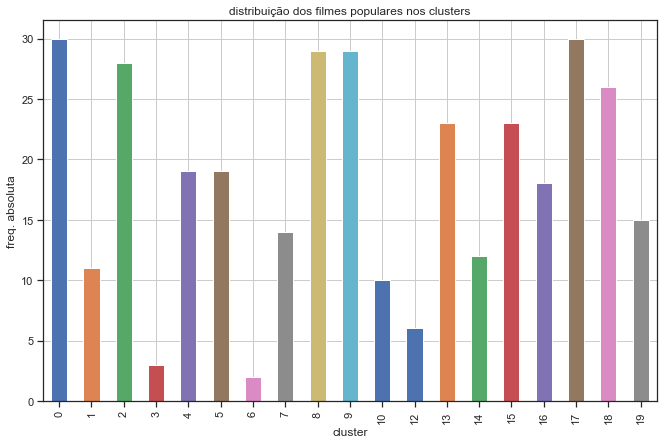

In [154]:
df_popular_1M, contagem_1M = where_popular(df_full_1M, popular_ids_1M)

**conclsão**
> Hà filmes populares em todos os clusters, mas são mais frequentes nos clusters 4 e 1

visualizando os filmes populares ao longo do clusters

In [155]:
list_n_films_from_clusters(df_popular_1M, 5)

Cluster 0
2000         LETHAL WEAPON (1987)
2006    MASK OF ZORRO, THE (1998)
457          FUGITIVE, THE (1993)
2001       LETHAL WEAPON 2 (1989)
1247         GRADUATE, THE (1967)
Name: movie_title, dtype: object
Cluster 1
296                                   PULP FICTION (1994)
2115          INDIANA JONES AND THE TEMPLE OF DOOM (1984)
2406                           ROMANCING THE STONE (1984)
1375           STAR TREK III: THE SEARCH FOR SPOCK (1984)
750     DR. STRANGELOVE OR: HOW I LEARNED TO STOP WORR...
Name: movie_title, dtype: object
Cluster 2
1250    BRIDGE ON THE RIVER KWAI, THE (1957)
2058                  NEGOTIATOR, THE (1998)
3499                           MISERY (1990)
1204               LAWRENCE OF ARABIA (1962)
3702                          MAD MAX (1979)
Name: movie_title, dtype: object
Cluster 3
3176    TALENTED MR. RIPLEY, THE (1999)
1225                     AMADEUS (1984)
3424          DO THE RIGHT THING (1989)
Name: movie_title, dtype: object
Cluster 4
2490         

## DBScan usando correlação como medida de dessimilaridade

In [190]:
def histogram_of_pairwise_dists(df, metric_):
    dists = pairwise_distances(df, metric=metric_)
    distis_ = pd.Series(dists.reshape(-1))
    plt.figure()
    distis_.hist()
    plt.title('histograma das correlações no dataset')
    plt.xlabel(metric_)
    plt.ylabel('freq')
    plt.show()

In [191]:
metric = 'correlation'

### Base de 100k

#### range para o ajuste de EPS

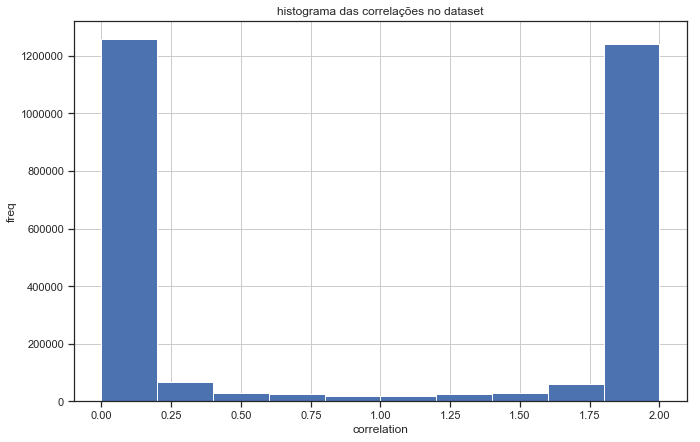

In [192]:
histogram_of_pairwise_dists(df_pca_100k, metric)

a partir do histograma, imagino que um valor de eps razoável seja ordens de grandeza abixo de 0.25

#### treinamento

In [167]:
dbscan_100k = DBSCAN(eps=.0025, min_samples=4, metric=metric).fit(df_pca_100k)

df_dbscan_100k = df_pca_100k.copy()
df_dbscan_100k['cluster'] = dbscan_100k.labels_

num_clusters_dbscan = (df_dbscan_100k['cluster'] != -1).nunique()

### Visualizando so resultados

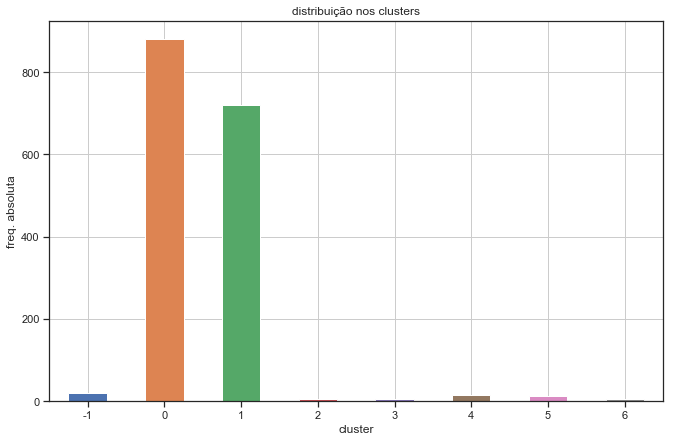

C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc

<Figure size 792x504 with 0 Axes>

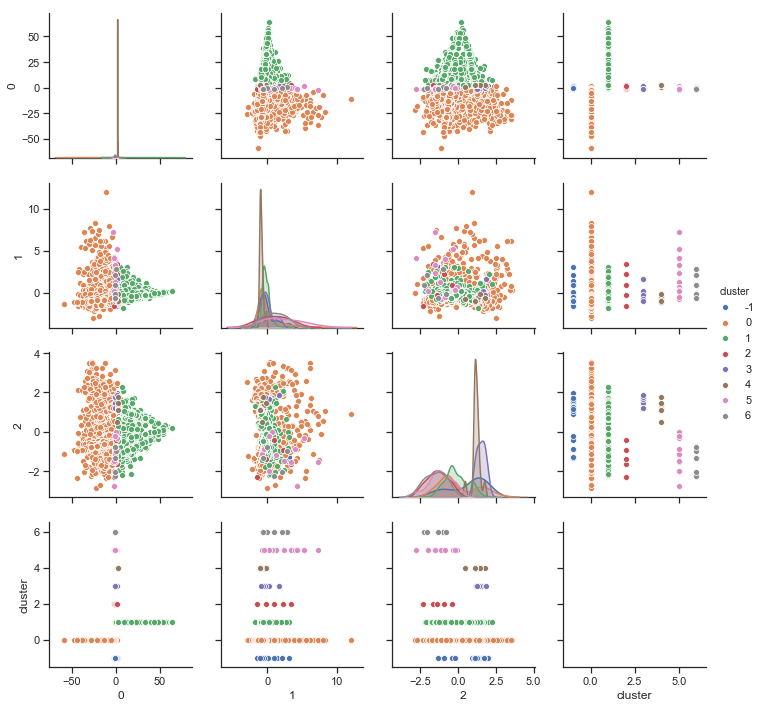

In [169]:
visualize_clusters(df_dbscan_100k)

após alguns testes, resolvi ficar com esses valores de eps e min_sample. Reaparei que a tendência é gerar dois grandes grupos separados por pequenos grupos que se distribuem ao longo do de um eixo quase paralelo a dimensão 1 do PCA

In [171]:
df_full_dbscan_100k = enrich_columns(df_dbscan_100k, to_enrich_100k)

In [172]:
df_full_dbscan_100k.head(5)

,pca_0,pca_1,pca_2,cluster,id,timestamp,movie_title,release_date,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,-24.735530,5.805738,-0.350249,0,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-4.009658,2.882217,2.483557,0,1.0,1998-02-17 17:28:52,Toy Story (1995),1995-01-01,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.331258,1.437456,-0.431839,-1,2.0,1997-09-30 16:14:13,GoldenEye (1995),1995-01-01,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-14.598549,1.232487,0.178331,0,3.0,1997-11-08 04:30:41,Four Rooms (1995),1995-01-01,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-6.915478,1.877837,-1.029404,0,4.0,1998-02-03 15:18:17,Get Shorty (1995),1995-01-01,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Intra cluster coesion

Coesão intra cluster usando Silhouette Coefficient:


>Compute the mean Silhouette Coefficient of all samples.
>
>The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for >each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and >the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 ><= n_labels <= n_samples - 1.


Idealmente esse coeficiente é 1 se a amostra pertece ao cluster

In [183]:
clusters_silh_dbscan_100k = calculate_silhouette_for_clusters(df_pca_100k, df_full_dbscan_100k['cluster'], metric)

Os clusters em ordem de coesão

In [184]:
clusters_silh_dbscan_100k.sort_values(['silhouete'], ascending=False)

,silhouete
labels,
4,0.998067
3,0.991863
6,0.961849
2,0.895579
1,0.894828
0,0.853899
5,0.482464
-1,-0.891548


**Conclusão**
> Os clusters são bem amais cosos que os obtidos através do PCA. O cluster de ruído tem silhoute negativa, o que é bem interessante, já que não é um cluster de fato

In [185]:
list_n_films_from_clusters(df_full_dbscan_100k, 10)

Cluster 0
1589                    Schizopolis (1996)
87      Searching for Bobby Fischer (1993)
352                     Spice World (1997)
367                        Clueless (1995)
219      Nightmare on Elm Street, A (1984)
523                  Cool Hand Luke (1967)
231                  Batman Returns (1992)
830                        Power 98 (1995)
956                   Nobody's Fool (1994)
5                           Copycat (1995)
Name: movie_title, dtype: object
Cluster 1
1173                                         Bliss (1997)
1146                                 Calendar Girl (1993)
876                                    Money Talks (1997)
1226                      Night Falls on Manhattan (1997)
1369    Forbidden Christ, The (Cristo proibito, Il) (1...
1568                         Vermont Is For Lovers (1992)
1281                                    Manny & Lo (1996)
1490                                        Fausto (1993)
1130                                Jupiter's Wife (1

#### Onde estão os filmes populares?

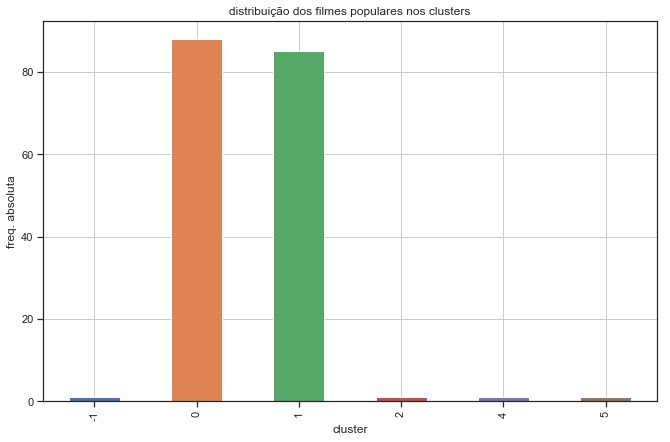

In [186]:
df_popular_dbscan_100k, contagem_dbscan_100k = where_popular(df_full_dbscan_100k, popular_ids_100k)

**conclsão**
> Hà filmes populares em todos os clusters, mas são mais frequentes nos clusters 0 e 1. Isso não chega a surpreeender, há que esses clusters são bem maiores

visualizando os filmes populares ao longo do clusters

In [187]:
list_n_films_from_clusters(df_popular_dbscan_100k, 5)

Cluster 0
480        North by Northwest (1959)
858     Amityville: Dollhouse (1996)
1291             Celtic Pride (1996)
778          Don Juan DeMarco (1995)
912            U.S. Marshalls (1998)
Name: movie_title, dtype: object
Cluster 1
1645               Butcher Boy, The (1998)
589                 Wild Bunch, The (1969)
1092                       Dear God (1996)
1278                         Selena (1997)
1610    Truth or Consequences, N.M. (1997)
Name: movie_title, dtype: object
Cluster 2
590    Hellraiser: Bloodline (1996)
Name: movie_title, dtype: object
Cluster 4
1094    Thin Line Between Love and Hate, A (1996)
Name: movie_title, dtype: object
Cluster 5
541    Mortal Kombat (1995)
Name: movie_title, dtype: object


### Base de 1M

#### range para o ajuste de EPS

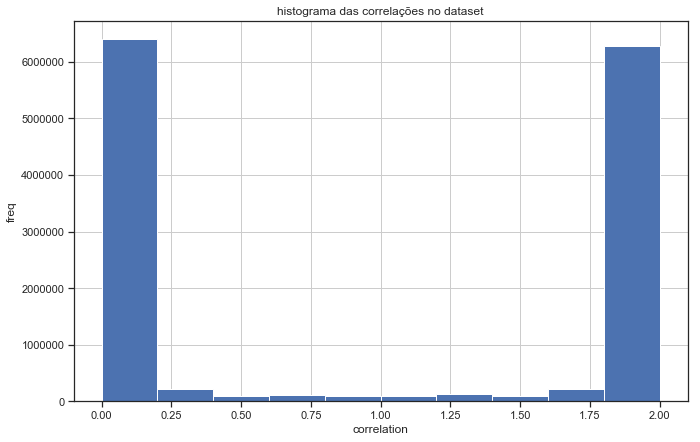

In [193]:
histogram_of_pairwise_dists(df_pca_1M, metric)

As correlações parecem bem similares as da base de 100k

#### treinamento

In [212]:
dbscan_1M = DBSCAN(eps=.0005, min_samples=3, metric=metric).fit(df_pca_1M)

df_dbscan_1M = df_pca_1M.copy()
df_dbscan_1M['cluster'] = dbscan_1M.labels_

num_clusters_dbscan = (df_dbscan_1M['cluster'] != -1).nunique()

### Visualizando so resultados

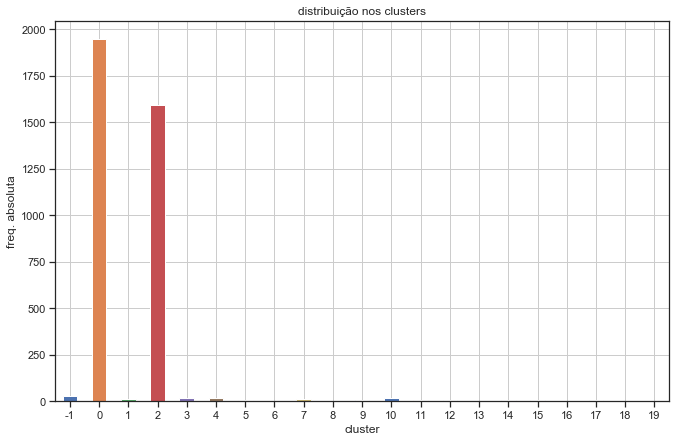

C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc

<Figure size 792x504 with 0 Axes>

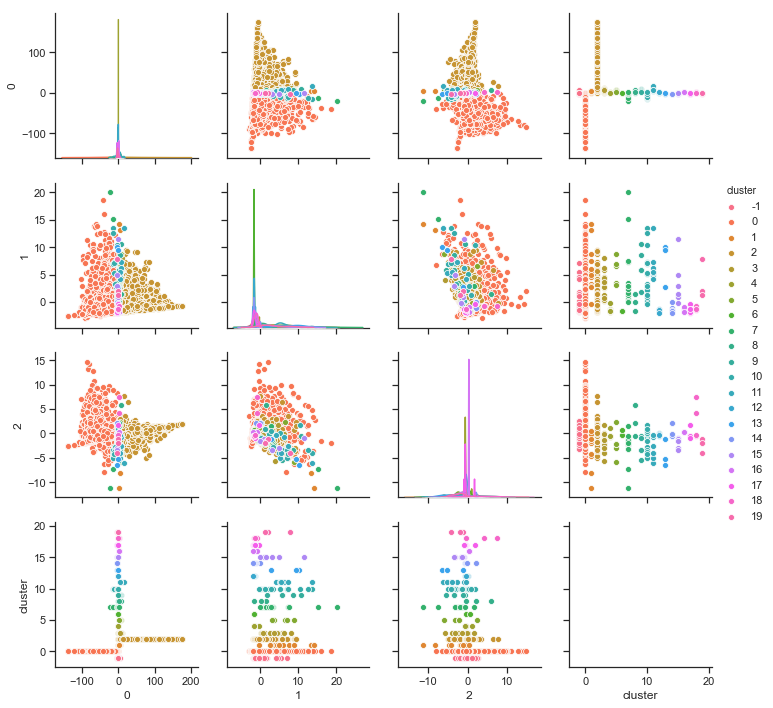

In [213]:
visualize_clusters(df_dbscan_1M)

após alguns testes, resolvi ficar com esses valores de eps e min_sample. Reaparei que a tendência é gerar dois grandes grupos separados por pequenos grupos que se distribuem ao longo do de um eixo quase paralelo a dimensão 1 do PCA

In [214]:
df_full_dbscan_1M = enrich_columns(df_dbscan_1M, to_enrich_1M)

In [215]:
df_full_dbscan_1M.head(5)

,pca_0,pca_1,pca_2,cluster,id,timestamp,movie_title,Genres
0,-70.706506,7.520658,3.235887,0,NaN,NaT,NaN,NaN
1,2.944293,5.531351,-1.904017,1,1.0,2001-01-06 23:37:48,TOY STORY (1995),Animation|Children's|Comedy
2,17.291953,2.307956,-1.671769,2,2.0,2001-01-10 23:11:07,JUMANJI (1995),Adventure|Children's|Fantasy
3,39.599425,-0.093002,-0.278462,2,3.0,2000-12-30 01:33:42,GRUMPIER OLD MEN (1995),Comedy|Romance
4,18.071306,1.770982,-1.927843,2,4.0,2000-12-31 03:10:03,WAITING TO EXHALE (1995),Comedy|Drama


#### Intra cluster coesion

Coesão intra cluster usando Silhouette Coefficient:


>Compute the mean Silhouette Coefficient of all samples.
>
>The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for >each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and >the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 ><= n_labels <= n_samples - 1.


Idealmente esse coeficiente é 1 se a amostra pertece ao cluster

In [216]:
clusters_silh_dbscan_1M = calculate_silhouette_for_clusters(df_pca_1M, df_full_dbscan_1M['cluster'], metric)

Os clusters em ordem de coesão

In [217]:
clusters_silh_dbscan_1M.sort_values(['silhouete'], ascending=False)

,silhouete
labels,
8,0.997661
6,0.997510
18,0.992864
9,0.982490
16,0.961033
13,0.959818
17,0.953641
5,0.940335
7,0.926216


**Conclusão**
> Os clusters são bem amais cosos que os obtidos através do PCA. O cluster de ruído tem silhoute negativa, o que é bem interessante, já que não é um cluster de fato

In [218]:
list_n_films_from_clusters(df_full_dbscan_1M, 10)

Cluster 0
880                 ISLAND OF DR. MOREAU, THE (1996)
2886    ADVENTURES OF ELMO IN GROUCHLAND, THE (1999)
513                         RADIOLAND MURDERS (1994)
3363                        AMERICAN GRAFFITI (1973)
2040          COMPUTER WORE TENNIS SHOES, THE (1970)
1935                  HOW GREEN WAS MY VALLEY (1941)
2418                        NOTHING IN COMMON (1986)
1877                               LITTLE MEN (1998)
2942                               FLASHDANCE (1983)
354                                      COBB (1994)
Name: movie_title, dtype: object
Cluster 1
702                                     FACES (1968)
1366                            CRUCIBLE, THE (1996)
2346                      STEPFORD WIVES, THE (1975)
3383                                             NaN
3456    COLOR OF PARADISE, THE (RANG-E KHODA) (1999)
2986                                ROBOCOP 2 (1990)
1737                                             NaN
1                                   TOY STORY 

#### Onde estão os filmes populares?

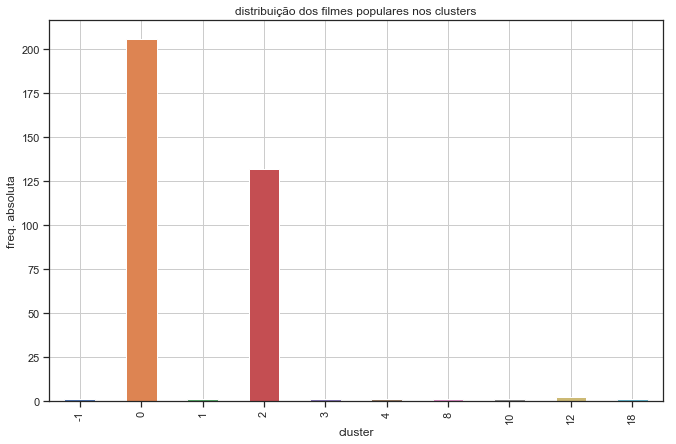

In [219]:
df_popular_dbscan_1M, contagem_dbscan_1M = where_popular(df_full_dbscan_1M, popular_ids_1M)

**conclsão**
> Hà filmes populares em todos os clusters, mas são mais frequentes nos clusters 0 e 2. Isso não chega a surpreeender, há que esses clusters são bem maiores

visualizando os filmes populares ao longo do clusters

In [220]:
list_n_films_from_clusters(df_popular_dbscan_1M, 5)

Cluster 0
34                    BABE (1995)
454              FIRM, THE (1993)
1270    BACK TO THE FUTURE (1985)
367              MASK, THE (1994)
2058       NEGOTIATOR, THE (1998)
Name: movie_title, dtype: object
Cluster 1
1    TOY STORY (1995)
Name: movie_title, dtype: object
Cluster 2
3448    GOOD MORNING, VIETNAM (1987)
733                 ROCK, THE (1996)
1682         TRUMAN SHOW, THE (1998)
1617        L.A. CONFIDENTIAL (1997)
1282                 FANTASIA (1940)
Name: movie_title, dtype: object
Cluster 3
2490    PAYBACK (1999)
Name: movie_title, dtype: object
Cluster 4
2791    AIRPLANE! (1980)
Name: movie_title, dtype: object
Cluster 8
2694    BIG DADDY (1999)
Name: movie_title, dtype: object


## DBScan usando a norma L2 como medida de dessimilaridade

Primeiro devemos determinar os hiperparâmetros
1. **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
2. **min_samples**: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

In [222]:
metric='euclidean'

### Base de 100k

#### range para o ajuste de EPS

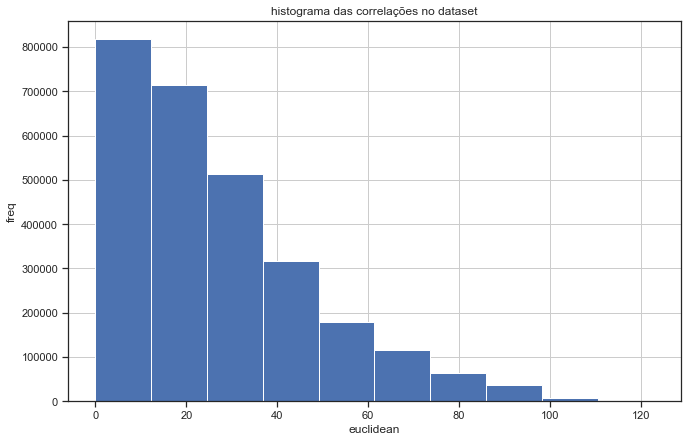

In [223]:
histogram_of_pairwise_dists(df_pca_100k, metric)

a partir do histograma, imagino que um valor de eps razoável seja ordens de grandeza abixo de 0.25

#### treinamento

In [228]:
dbscan_100k = DBSCAN(eps=1, min_samples=10, metric=metric).fit(df_pca_100k)

df_dbscan_100k = df_pca_100k.copy()
df_dbscan_100k['cluster'] = dbscan_100k.labels_

num_clusters_dbscan = (df_dbscan_100k['cluster'] != -1).nunique()

### Visualizando so resultados

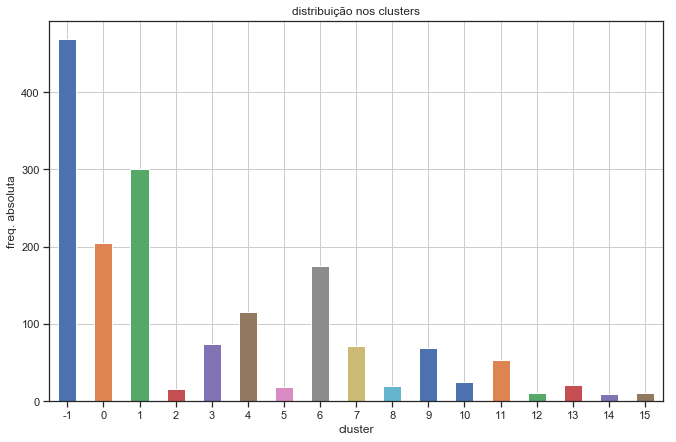

C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc

<Figure size 792x504 with 0 Axes>

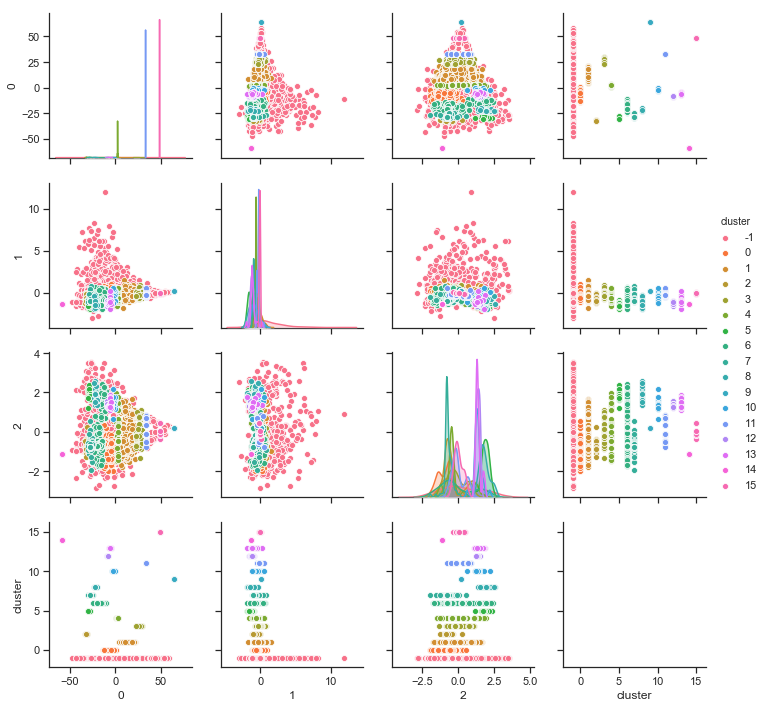

In [229]:
visualize_clusters(df_dbscan_100k)

**observações**
> Desta vez o dbscan gerou clusters que parecem conditdos em cubos alinhados aos eixos do PCA, ou seja separados por planos ortogonais aos eixos.

In [230]:
df_full_dbscan_100k = enrich_columns(df_dbscan_100k, to_enrich_100k)

In [231]:
df_full_dbscan_100k.head(5)

,pca_0,pca_1,pca_2,cluster,id,timestamp,movie_title,release_date,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,-24.735530,5.805738,-0.350249,-1,NaN,NaT,NaN,NaT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-4.009658,2.882217,2.483557,-1,1.0,1998-02-17 17:28:52,Toy Story (1995),1995-01-01,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.331258,1.437456,-0.431839,-1,2.0,1997-09-30 16:14:13,GoldenEye (1995),1995-01-01,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-14.598549,1.232487,0.178331,-1,3.0,1997-11-08 04:30:41,Four Rooms (1995),1995-01-01,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-6.915478,1.877837,-1.029404,-1,4.0,1998-02-03 15:18:17,Get Shorty (1995),1995-01-01,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Intra cluster coesion

Coesão intra cluster usando Silhouette Coefficient:


>Compute the mean Silhouette Coefficient of all samples.
>
>The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for >each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and >the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 ><= n_labels <= n_samples - 1.


Idealmente esse coeficiente é 1 se a amostra pertece ao cluster

In [232]:
clusters_silh_dbscan_100k = calculate_silhouette_for_clusters(df_pca_100k, df_full_dbscan_100k['cluster'], metric)

Os clusters em ordem de coesão

In [233]:
clusters_silh_dbscan_100k.sort_values(['silhouete'], ascending=False)

,silhouete
labels,
14,1.000000
9,1.000000
15,0.978332
11,0.927600
2,0.787764
4,0.784982
8,0.752507
12,0.671445
5,0.612299


In [234]:
list_n_films_from_clusters(df_full_dbscan_100k, 10)

Cluster 0
857                   Paris Was a Woman (1995)
1001                       Stupids, The (1996)
357     One Flew Over the Cuckoo's Nest (1975)
1285                   Princess Caraboo (1994)
826                        Phantom, The (1996)
355                              Sphere (1998)
986                          Turbulence (1997)
981                    Dangerous Ground (1997)
940                            Airheads (1994)
469                          Short Cuts (1993)
Name: movie_title, dtype: object
Cluster 1
1098    Flirting With Disaster (1996)
263                      Steel (1997)
1542       Scarlet Letter, The (1926)
1243               Night Flier (1997)
1284          Before and After (1996)
831           Escape from L.A. (1996)
753           Burnt By the Sun (1994)
537       My Own Private Idaho (1991)
923      Raise the Red Lantern (1991)
1135                Doors, The (1991)
Name: movie_title, dtype: object
Cluster 2
312     Midnight in the Garden of Good and Evil (1997)

#### Onde estão os filmes populares?

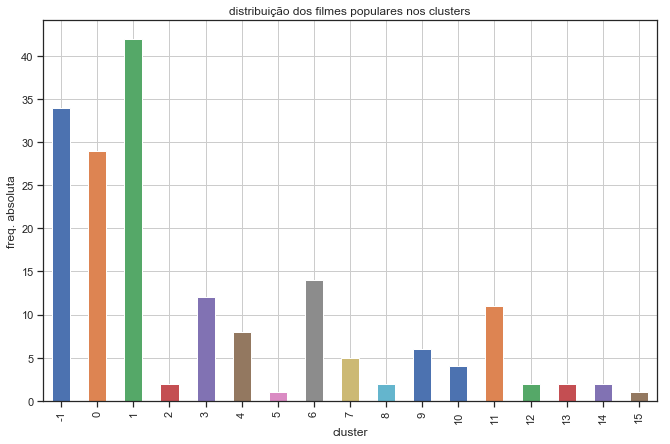

In [235]:
df_popular_dbscan_100k, contagem_dbscan_100k = where_popular(df_full_dbscan_100k, popular_ids_100k)

**conclsão**
> Hà filmes populares em todos os clusters, mas são mais frequentes nos clusters 0 e 1. que são pouco coesos

visualizando os filmes populares ao longo do clusters

In [236]:
list_n_films_from_clusters(df_popular_dbscan_100k, 5)

Cluster 0
344                Apostle, The (1997)
733                     Go Fish (1994)
454     Bastard Out of Carolina (1996)
329          Desperate Measures (1998)
1302              Late Bloomers (1996)
Name: movie_title, dtype: object
Cluster 1
1198                         Purple Noon (1960)
1358                     The Deadly Cure (1996)
904     Ma vie en rose (My Life in Pink) (1997)
349                            Hard Rain (1998)
589                      Wild Bunch, The (1969)
Name: movie_title, dtype: object
Cluster 2
474    Dr. Strangelove or: How I Learned to Stop Worr...
165                              Jean de Florette (1986)
Name: movie_title, dtype: object
Cluster 3
1517            Race the Sun (1996)
1219          Goofy Movie, A (1995)
34      Doom Generation, The (1995)
1608                   Buddy (1997)
1278                  Selena (1997)
Name: movie_title, dtype: object
Cluster 4
1206      Amos & Andrew (1993)
1288    Denise Calls Up (1995)
1320             Homage (19

### Base de 1M

#### range para o ajuste de EPS

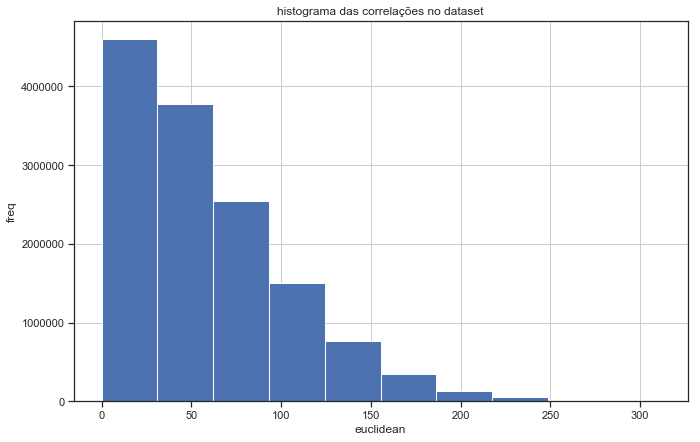

In [237]:
histogram_of_pairwise_dists(df_pca_1M, metric)

As correlações parecem bem similares as da base de 100k

#### treinamento

In [258]:
dbscan_1M = DBSCAN(eps=1.5, min_samples=10, metric=metric).fit(df_pca_1M)

df_dbscan_1M = df_pca_1M.copy()
df_dbscan_1M['cluster'] = dbscan_1M.labels_

num_clusters_dbscan = (df_dbscan_1M['cluster'] != -1).nunique()

### Visualizando so resultados

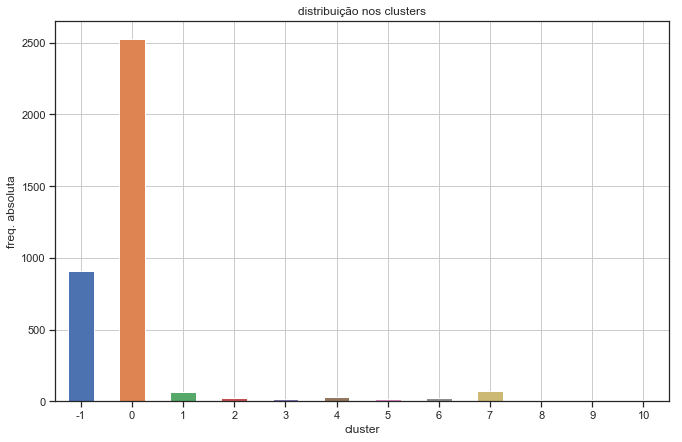

C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc

<Figure size 792x504 with 0 Axes>

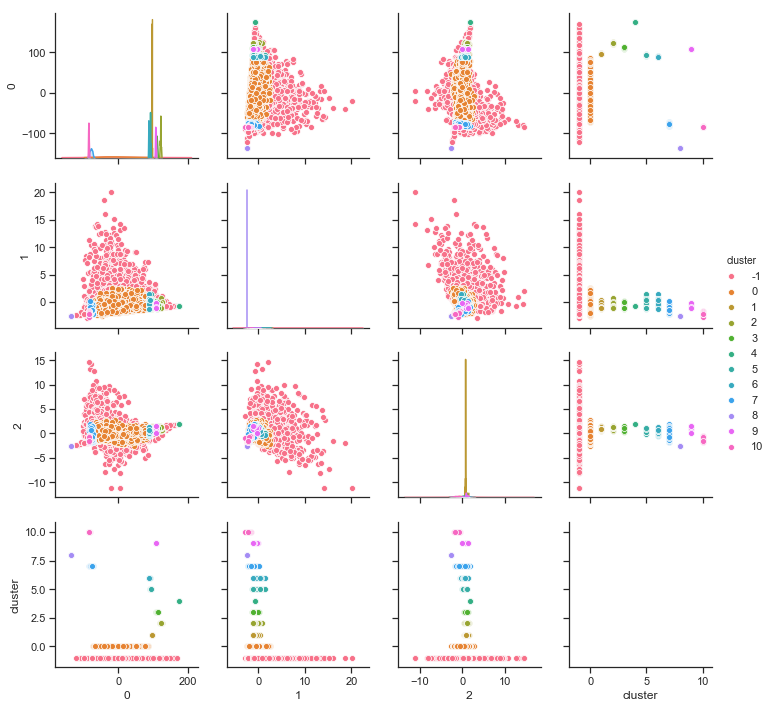

In [259]:
visualize_clusters(df_dbscan_1M)

Desta vez foi muito mais difícil diminuir o grupo de ruído e o parâetro eps foi consideravalmente maior

In [260]:
df_full_dbscan_1M = enrich_columns(df_dbscan_1M, to_enrich_1M)

In [261]:
df_full_dbscan_1M.head(5)

,pca_0,pca_1,pca_2,cluster,id,timestamp,movie_title,Genres
0,-70.706506,7.520658,3.235887,-1,NaN,NaT,NaN,NaN
1,2.944293,5.531351,-1.904017,-1,1.0,2001-01-06 23:37:48,TOY STORY (1995),Animation|Children's|Comedy
2,17.291953,2.307956,-1.671769,0,2.0,2001-01-10 23:11:07,JUMANJI (1995),Adventure|Children's|Fantasy
3,39.599425,-0.093002,-0.278462,0,3.0,2000-12-30 01:33:42,GRUMPIER OLD MEN (1995),Comedy|Romance
4,18.071306,1.770982,-1.927843,0,4.0,2000-12-31 03:10:03,WAITING TO EXHALE (1995),Comedy|Drama


#### Intra cluster coesion

Coesão intra cluster usando Silhouette Coefficient:


>Compute the mean Silhouette Coefficient of all samples.
>
>The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for >each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and >the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 ><= n_labels <= n_samples - 1.


Idealmente esse coeficiente é 1 se a amostra pertece ao cluster

In [262]:
clusters_silh_dbscan_1M = calculate_silhouette_for_clusters(df_pca_1M, df_full_dbscan_1M['cluster'], metric)

Os clusters em ordem de coesão

In [263]:
clusters_silh_dbscan_1M.sort_values(['silhouete'], ascending=False)

,silhouete
labels,
4,1.000000
8,1.000000
1,0.923266
2,0.859152
10,0.814551
6,0.626632
9,0.593074
5,0.521210
3,0.357468


**Conclusão**
> Os clusters 0 e -1 são novamente pouco coesos. 

In [264]:
list_n_films_from_clusters(df_full_dbscan_1M, 10)

Cluster 0
2289              PLAYER, THE (1992)
3131          BROADWAY DAMAGE (1997)
635           FAMILY THING, A (1996)
2566         DOUG'S 1ST MOVIE (1999)
372             REALITY BITES (1994)
3154         BLOOD ON THE SUN (1945)
1805              WILD THINGS (1998)
766        I SHOT ANDY WARHOL (1996)
3145    CRADLE WILL ROCK, THE (1999)
2805         MICKEY BLUE EYES (1999)
Name: movie_title, dtype: object
Cluster 1
624          CONDITION RED (1995)
1698                          NaN
1688             ANASTASIA (1997)
1407                SCREAM (1996)
2064            ROGER & ME (1989)
3065             TEN BENNY (1997)
2075              MEPHISTO (1981)
531     SECRET GARDEN, THE (1993)
662                   FEAR (1996)
3445    EYES OF LAURA MARS (1978)
Name: movie_title, dtype: object
Cluster 2
1415                     THIEVES (VOLEURS, LES) (1996)
3424                         DO THE RIGHT THING (1989)
615     BREAD AND CHOCOLATE (PANE E CIOCCOLATA) (1973)
3176                   TALENT

#### Onde estão os filmes populares?

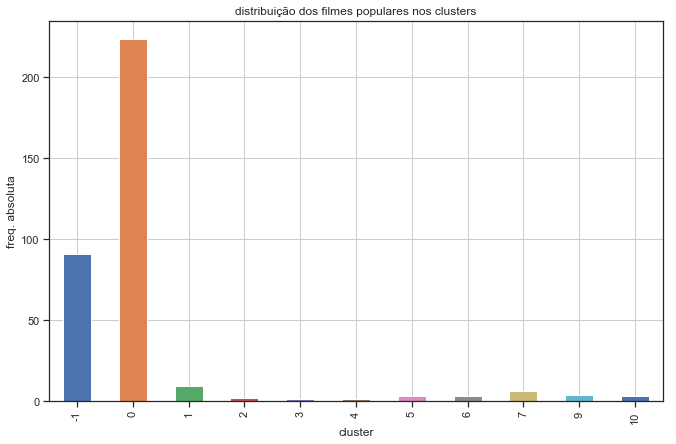

In [265]:
df_popular_dbscan_1M, contagem_dbscan_1M = where_popular(df_full_dbscan_1M, popular_ids_1M)

**conclsão**
> Hà filmes populares em todos os clusters, mas são mais frequentes nos clusters 0 e -1. Isso não chega a surpreeender, há que esses clusters são bem maiores

visualizando os filmes populares ao longo do clusters

In [266]:
list_n_films_from_clusters(df_popular_dbscan_1M, 5)

Cluster 0
3114                               TOY STORY 2 (1999)
1372    STAR TREK VI: THE UNDISCOVERED COUNTRY (1991)
3526                                PARENTHOOD (1989)
3450                            GRUMPY OLD MEN (1993)
2023                  GODFATHER: PART III, THE (1990)
Name: movie_title, dtype: object
Cluster 1
2746    LITTLE SHOP OF HORRORS (1986)
1641           FULL MONTY, THE (1997)
3255    LEAGUE OF THEIR OWN, A (1992)
1673             BOOGIE NIGHTS (1997)
1407                    SCREAM (1996)
Name: movie_title, dtype: object
Cluster 2
3424          DO THE RIGHT THING (1989)
3176    TALENTED MR. RIPLEY, THE (1999)
Name: movie_title, dtype: object
Cluster 3
1376    STAR TREK IV: THE VOYAGE HOME (1986)
Name: movie_title, dtype: object
Cluster 4
3006    INSIDER, THE (1999)
Name: movie_title, dtype: object
Cluster 5
1080    MONTY PYTHON'S LIFE OF BRIAN (1979)
1682                TRUMAN SHOW, THE (1998)
3448           GOOD MORNING, VIETNAM (1987)
Name: movie_title, dtype: obje

# Conclusão

**Vetores de features e PCA**

Os vetores de features (notas dadas por todos os usuários para o filme) realmente eram esparsos como se esperava. A nédia dos filmes recebeu 59 notas, mas a distribição do número de usuários que deu nota pra os filmes é altamente assimétrica e a moda da distribuição é 1. Por isso, o PCA reduziu bastante as dimensões do problema e 3 componentes representam quase 90% da energia total dos vetores de features. Com a dimensão reduzida, foi possível rodar os alogoritmos em tempo viável.

Os filmes populares, que foram definidos com aqueles com um grande número de notas diferentes de 0. Utilizei o box plot para determinar um limiar de 100 para esses filmes, o que faz com que 333 filmes sejam considerados populares.

**Clusterização KMeans**

A função de loss (somatório das distâncias ao quadrado dos pontos aos centróides de seus clusters) apresentou um "joeçho" em 10 clusters e por isso esse foi o número de clusters que foi utilizado. Os clusters obtidos pelo Kmenas
são paralelos a dimensão 0 do PCA (a de maior variância) e, a exceção de uns poucos, são formados por um grande número de filmes.

O algoritmo parece distribuiu os filmes populares entre os clusters. 

**Clusterização DBScan**

o ajuste dos hiper-parâmetros do algoritmo DBScan foi menos sistemático já que a ausência do conceito de uma função de loss que seja minimizada dificulta essa avaliação. O que se observou foi que:

* Se diminuimos o eps, mantendo-se o mesmo valor de min_samples, o grupo 0 aumenta e o grupo -1 (ruído) diminui
* Se mantemos o valor de eps fixo e aumentamos o valor de min_samples, o número de clusters diminui e o tamanho do grupo -1 (ruído) também aumenta.

O espaço de features abstrato, isto é, a transformada PCA dos vetores de features, dificultou bastante a escolha de parâmetros adequados.  De modo geral, eu variei o valor de epsc até obter clusters em grande número (> 20) e depois para um valor baixo de min_samples e depois aumentei o valor de min_samples pra reduzir os clusters criadoss.

Reparei que a tendência do algoritimo foi gerar dois grandes clusters nas extremidades da nuvem de dados separados por pequenos clusters em um "equador" se usamos a métrica de correlação. Com a métrica euclideana, os clusters fiam mais alinhados aos eixos do PCA e são rodeados por ruído. 

O algoritmo não parece sensível aos filmes populares já que a maioria deles caiu em grupos pouco coesos.

**Considerações**

de forma geral, achei que nenhuma das variações de algoritmos de clusterização e métricas gerou clusters coesos, apesar dos score shilouete alto em alguns casos. Acredito que outras features seriam importantes como, po exemplo, os gêneros dos filmes. Acredito que outras métricas de dissimilaridades compostas não apenas pela distância euclideana, mas também pela norma L0 (pra tentar dar mais peso aos filmes que foram vistos pelos mesmos usuários, independetemente das notas que derem, poderia auxiliar.